# VGG

In [ ]:
name = 'vgg'

In [2]:
# Import needed libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import utilities
from tensorflow.keras.layers import Input, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.models import Model

In [3]:
# Check Tensorflow version
print('Tensorflow version: ',tf.__version__)
# Check if GPU is being used
print('GPU available: ', tf.config.list_physical_devices('GPU'))
# If a GPU is being used, check that it's not being used by another process as well
if tf.config.list_physical_devices('GPU'):
  print("GPU usage: ", tf.config.experimental.get_memory_info('GPU:0'))

Tensorflow version:  2.10.1
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU usage:  {'current': 0, 'peak': 0}


## Load the data

In [4]:
def process_image(path, label):
    # Desired size
    size = 250
    # Get the image
    img = tf.io.read_file(path)
    # Decode the PNG
    img = tf.image.decode_png(img)
    # Resize image
    img = tf.image.resize(img, (size, size))
    # Reshape image (this is not necessary but I do it so that I don't need to be modifying the shape in the input layer)
    img = tf.reshape(img, [size, size, 1])
    # Cast image to float32
    img = tf.cast(img, tf.float32)
    # Normalize image
    img = img/255.0

    return img, label

In [5]:
def get_paths_n_labels(csv_path, images_folder_path, id_col, label_col):
    df = pd.read_csv(csv_path)
    paths = [images_folder_path + '/' + str(id) + '.png' for id in df[id_col].tolist()]
    labels = df[label_col].tolist()
    return paths, labels

In [9]:
# Dataset used
ds = 'clahecropfix_r250'

# Input pipeline
# Training set
train_paths, train_labels = get_paths_n_labels( csv_path='./data/pre_processed/training/train.csv',
                                                images_folder_path='./data/pre_processed/training/{}'.format(ds),
                                                id_col='id',
                                                label_col='boneage')
train_dataset = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_dataset = train_dataset.map(process_image)
train_dataset = train_dataset.shuffle(len(train_dataset)).batch(32)

#Validation set
validation_paths, validation_labels = get_paths_n_labels(
                                                csv_path='./data/pre_processed/validation/validation/validation.csv',
                                                images_folder_path='./data/pre_processed/validation/validation/{}'.format(ds),
                                                id_col='Image ID',
                                                label_col='Bone Age (months)')
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_paths, validation_labels))
validation_dataset = validation_dataset.map(process_image).batch(32)

In [ ]:
# for img, label in train_dataset:
#     print(type(img))
#     break

## Instantiate the model

In [ ]:
# Build the model using the functional API
i = Input(shape=train_dataset.element_spec[0].shape[1:])
x = Conv2D(8, (3,3), activation='relu', padding='same')(i)
x = BatchNormalization()(x)
x = Conv2D(8, (3,3), activation='relu', padding='same')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(16, (3,3), activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same')(x)
x = BatchNormalization()(x)
x = Conv2D(32, (3,3), strides=2, activation='relu', padding='same' )(x)
x = MaxPooling2D((2,2))(x)
x = Flatten()(x)
x = Dropout(0.2)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(1)(x)

model = Model(i,x)

In [ ]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='mse',
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [ ]:
model.summary()

In [ ]:
# To make that the learning rate decreases
def schedule(epoch, lr):
    if epoch>=50:
        return 0.0001
    return 0.001
scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)

In [ ]:
# Experiment tracking with tensorboard
import time
experiment_name = "{}_{}_{}".format(name,ds,int(time.time()))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir='./logs/{}'.format(experiment_name))

## Training ("fit") the model

In [ ]:
# Fit the model
r = model.fit(train_dataset, validation_data=validation_dataset, epochs=50, callbacks=[scheduler, tensorboard])

## Save the model

In [ ]:
# Let's now save our model to a file
model.save('./models/{}.h5'.format(experiment_name))

## Make predictions

In [10]:
# Load the model
model = tf.keras.models.load_model('./models/vgg_clahecropfix_r250_1676027847.h5')
model.evaluate(validation_dataset)

45/45 [==============================] - 2s 26ms/step - loss: 475.3775 - root_mean_squared_error: 21.8032


[475.37750244140625, 21.80315399169922]

In [11]:
p_test = model.predict(validation_dataset).reshape(-1)

45/45 [==============================] - 1s 27ms/step


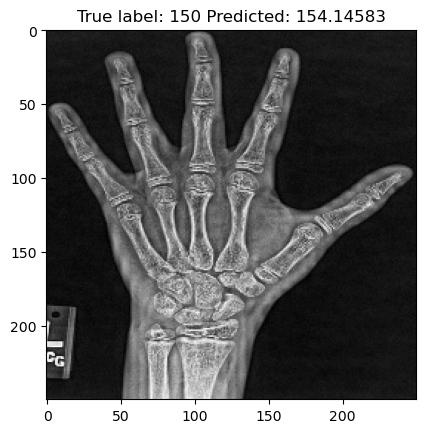

In [15]:
# Show some misclassified examples
y_test = np.array([y.numpy() for x, y in validation_dataset.unbatch()])
x_test = np.array([x.numpy() for x, y in validation_dataset.unbatch()])
difference = np.abs(np.subtract(y_test, p_test))
misclassified_idx = np.where(difference>4)
#print(misclassified_idx)
i = np.random.choice(misclassified_idx[0])
plt.imshow(x_test[i], cmap='gray')
plt.title("True label: %s Predicted: %s" % (y_test[i], p_test[i]));